In [2]:
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
%matplotlib inline

In [198]:
N = 100
X = jnp.linspace(-5, 5, N)
f = jnp.sin(X) + (X**2) 
y = f + tfd.Normal(loc = 0, scale = 2).sample(seed = jax.random.PRNGKey(0), sample_shape = (N, ))


train_idx = jax.random.choice(key = jax.random.PRNGKey(0), a=jnp.arange(N), shape=[int(N/2)]).sort()
X_train = X[train_idx]
y_train = y[train_idx]

X_test = X[~train_idx]
y_test = y[~train_idx]

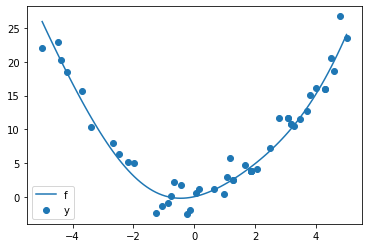

In [199]:
plt.plot(X, f, label='f')
plt.scatter(X_train, y[train_idx], label='y')
plt.legend()

X = X.reshape(-1, 1)

In [200]:
def rbf_kernel(x: jnp.array, y: jnp.array, l=1., s=1.):
    tau = jnp.sum(jnp.square(x / l - y / l))
    return s * jnp.exp(-0.5 * tau)

In [201]:
mv_rbf = jax.vmap(rbf_kernel, (0, None, None, None))
mm_rbf = jax.vmap(mv_rbf, (None, 0, None, None))

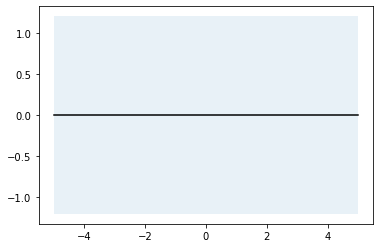

In [332]:
l = 1.0
s = 1.0
noise = 0.1
N_points = 100
X = jnp.linspace(-5,5, N_points)

dist = tfd.MultivariateNormalFullCovariance(
        loc=0.0, covariance_matrix=mm_rbf(X, X, l, s) + noise * 2 * jnp.eye(N_points))
plt.fill_between(X, dist.mean() - dist.variance(), dist.mean() + dist.variance(), alpha=0.1)
plt.plot(X, dist.mean(), color='k')
samples = dist.sample(seed = jax.random.PRNGKey(1), sample_shape = (500,))


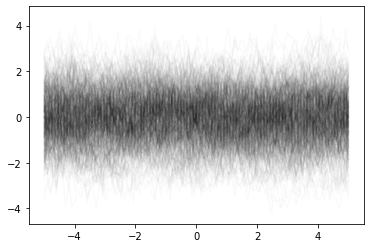

In [333]:
for sample in samples:
    plt.plot(X, sample, color='k', alpha=0.02)

In [337]:
.shape

(1, 100)

ValueError: x and y must have same first dimension, but have shapes (1, 100) and (500, 100)

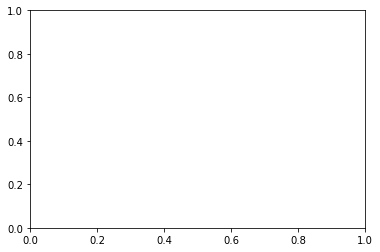

In [338]:
plt.plot(X[jnp.newaxis, :], samples)

In [202]:
k = mm_rbf(X_train, X_train, .5, 5.0)

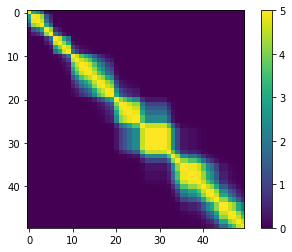

In [203]:
plt.imshow(k)
plt.colorbar()

In [339]:
@jax.jit
def loss(l, s, noise, X, y):
    N_points = X.shape[0]
    dist = tfd.MultivariateNormalFullCovariance(
        loc=0.0, covariance_matrix=mm_rbf(X, X, l, s) + noise * 2 * jnp.eye(N_points)
    )
    return -dist.log_prob(y)

In [340]:
l = 2.0
s = 1.0
noise = 1.0



In [345]:
X_test = jnp.linspace(-10, 10, 100).reshape(-1, 1)


In [346]:
lr = 0.01
for i in range(100):
    loss_val, delta = jax.value_and_grad(loss, [0, 1, 2])(l, s, noise, X_train, y_train)
    if i%10==0: print(loss_val, i)
    l = l - delta[0]*lr
    s = s - delta[1]*lr
    noise = noise - delta[2]*lr
    

422.77652 0
184.01344 10
173.15698 20
167.2399 30
163.26053 40
160.28217 50
157.90308 60
155.91875 70
154.21344 80
152.71678 90


In [347]:
def predict(X_test):
    N_star = len(X_test)
    K = mm_rbf(X_train, X_train, l, s)
    K_star = mm_rbf(X_train, X_test, l, s)
    K_star_star = mm_rbf(X_test, X_test, l, s)
    K_inv = jnp.linalg.inv(K + noise**2*jnp.eye(len(X_train)))
    posterior_mu = K_star@K_inv@(y_train)
    posterior_sigma = K_star_star - K_star@K_inv@K_star.T
    return posterior_mu, posterior_sigma

In [348]:
posterior_mu, posterior_sigma = predict(X_test)

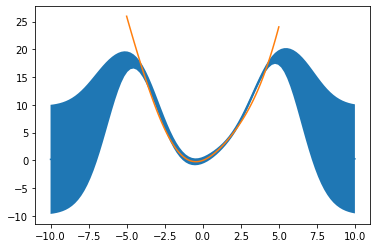

In [349]:
plt.plot(X_test, posterior_mu)
plt.fill_between(X_test.flatten(), posterior_mu - jnp.diag(posterior_sigma), posterior_mu + jnp.diag(posterior_sigma))
plt.plot(X, f)

In [350]:
l, s, noise

(DeviceArray(1.7486757, dtype=float32, weak_type=True),
 DeviceArray(9.824895, dtype=float32, weak_type=True),
 DeviceArray(2.613888, dtype=float32, weak_type=True))

In [358]:
jnp.diag(posterior_sigma)

DeviceArray([9.82289   , 9.821097  , 9.817891  , 9.812317  , 9.802897  ,
             9.787426  , 9.762734  , 9.724448  , 9.6667795 , 9.582415  ,
             9.462575  , 9.297328  , 9.076207  , 8.789184  , 8.427933  ,
             7.9873257 , 7.4668922 , 6.8720665 , 6.2148895 , 5.5139427 ,
             4.793332  , 4.0807633 , 3.4048657 , 2.792099  , 2.26374   ,
             1.8335185 , 1.5061588 , 1.2773542 , 1.1349821 , 1.0613785 ,
             1.0363884 , 1.0402737 , 1.0562668 , 1.0721178 , 1.0804462 ,
             1.0781574 , 1.0650778 , 1.0424509 , 1.0117207 , 0.9738741 ,
             0.92957973, 0.8796997 , 0.8259697 , 0.77138996, 0.7200098 ,
             0.6760998 , 0.64304256, 0.62219334, 0.6122942 , 0.609642  ,
             0.60905933, 0.6053734 , 0.59490585, 0.5765543 , 0.5519953 ,
             0.52508163, 0.50055313, 0.48256016, 0.47350597, 0.4735117 ,
             0.48061562, 0.49158764, 0.5029545 , 0.51190567, 0.5168867 ,
             0.51778984, 0.5160208 , 0.51458645, 0.

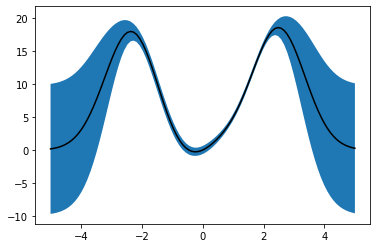

In [360]:
dist = tfd.MultivariateNormalFullCovariance(
        loc=posterior_mu, covariance_matrix=posterior_sigma)
plt.fill_between(X, posterior_mu - jnp.diag(posterior_sigma), posterior_mu + jnp.diag(posterior_sigma), alpha=1)
plt.plot(X, dist.mean(), color='k')
samples = dist.sample(seed = jax.random.PRNGKey(1), sample_shape = (500,))

In [352]:
posterior_sigma

DeviceArray([[9.8228903e+00, 9.7567892e+00, 9.5623627e+00, ...,
              3.6079568e-06, 2.5671284e-06, 1.8000273e-06],
             [9.7567892e+00, 9.8210974e+00, 9.7543936e+00, ...,
              5.3180474e-06, 3.7921177e-06, 2.6647720e-06],
             [9.5623627e+00, 9.7543936e+00, 9.8178911e+00, ...,
              7.7175291e-06, 5.5142518e-06, 3.8827816e-06],
             ...,
             [3.6079537e-06, 5.3180465e-06, 7.7175282e-06, ...,
              9.8163223e+00, 9.7532454e+00, 9.5615349e+00],
             [2.5671268e-06, 3.7921156e-06, 5.5142509e-06, ...,
              9.7532454e+00, 9.8202591e+00, 9.7561855e+00],
             [1.8000261e-06, 2.6647708e-06, 3.8827807e-06, ...,
              9.5615349e+00, 9.7561855e+00, 9.8224545e+00]],            dtype=float32)